In [0]:
# imporr libraries
import torch.nn as nn
import torch
import autograd.numpy as np
import pandas as pd
from pyDOE import lhs
from autograd import grad,elementwise_grad
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

## Q1

In [0]:
#define neural network
class VanillaNN():
  def __init__(self,N):
    X = 4 * lhs(2, N) + 50
    y = np.multiply(np.cos(np.pi * X[:,0]),np.cos(np.pi * X[:,1]))
    #Add bias term and normalize both input and outputhere
    self.X = np.hstack([(X - np.mean(X,axis = 0))/ np.std(X,axis = 0),np.ones((X.shape[0],1))])
    self.y = ((y - np.mean(y,axis = 0)) / np.std(y,axis = 0)).reshape(X.shape[0],1)
    #split up into train/test set
    X_test = 4 * lhs(2, 100) + 50
    y_test = np.multiply(np.cos(np.pi * X_test[:,0]),np.cos(np.pi * X_test[:,1]))
    self.X_test = np.hstack([(X_test - np.mean(X_test,axis = 0))/ np.std(X_test,axis = 0),np.ones((X_test.shape[0],1))])
    self.y_test = ((y_test - np.mean(y_test,axis = 0)) / np.std(y_test,axis = 0)).reshape(X_test.shape[0],1)    
    #initialize weights here
    self.W1 = np.vstack((np.random.randn(2,50) * np.sqrt(1 / 26), np.zeros((1,50))))
    self.W2 = np.vstack((np.random.randn(50,50) * np.sqrt(1 / 50),np.zeros((1,50))))
    self.W3 = np.vstack((np.random.randn(50,1) * np.sqrt(2 / 51),np.zeros((1,1))))
    #hyper parameters
    self.iteration_num = 5000
    self.beta_one = .9
    self.beta_two = .999
    self.epsilon = 1e-8
    
  def forward(self,X,W1,W2,W3):
    out = np.matmul(X,W1)
    out = np.hstack([np.tanh(out),np.ones((out.shape[0],1))])
    out = np.matmul(out,W2)
    out = np.hstack([np.tanh(out),np.ones((out.shape[0],1))])
    out = np.matmul(out,W3)
    return out
  
  def mse_loss(self,X,y,W1,W2,W3):
    y_hat = self.forward(X,W1,W2,W3)
    loss = np.dot((y - y_hat).T,(y -y_hat)) / X.shape[0]
    return loss  
  
  def optimizer(self,learning_rate):
    locator = 0
    W = [self.W1,self.W2,self.W3]
    m = [np.zeros(w.shape) for w in W]
    v = [np.zeros(w.shape) for w in W]
    grad_losses = [grad(self.mse_loss,num) for num in [2,3,4]]
    for iter_num in range(self.iteration_num):
      for i in range(3):
        this_loss_gradient = grad_losses[i](self.X,self.y,*W)
        m[i] = self.beta_one * m[i] + (1 - self.beta_one) * this_loss_gradient
        v[i] = self.beta_two * v[i] + (1 - self.beta_two) * np.multiply(this_loss_gradient,this_loss_gradient)
        m_dot = m[i] / (1 - self.beta_one ** (iter_num + 1))
        v_dot = v[i] / (1 - self.beta_two ** (iter_num + 1))
        W[i] -= learning_rate * m_dot / (np.sqrt(v_dot) + self.epsilon)
    return W
  
  def l2_error(self):
    W = self.optimizer(.001)
    pred_y_norm = self.forward(self.X_test,*W)
    displacement = pred_y_norm - self.y_test
    return np.linalg.norm(displacement) / np.linalg.norm(self.y_test)

Text(0, 0.5, 'L2 error')

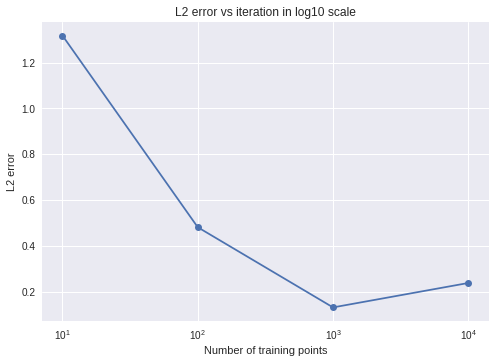

In [0]:
l2_errors = []
for N in [10,100,1000,10000]:
  vnn = VanillaNN(N)
  l2_error = vnn.l2_error()
  l2_errors.append(l2_error)
plt.plot([10,100,1000,10000],l2_errors,marker='o')
plt.title('L2 error vs iteration in log10 scale')
plt.xscale('log')
plt.xlabel('Number of training points')
plt.ylabel('L2 error')

## Q2

In [0]:
# implement Phisically informed NN
class PhysicallyInformedNN(VanillaNN):
  def __init__(self,N):
    # including bias
    self.X_Nu = np.array([[-1,1],[1,1]])
    self.y_Nu = np.array([[0,0]]).T
    self.N = N
    self.X_Nf = np.hstack((2 * lhs(1, self.N) - 1,np.ones((self.N,1))))
    self.X_test = np.hstack((2 * lhs(1, 100) - 1,np.ones((100,1))))
    self.y_test = np.sin(np.pi * self.X_test[:,0]).reshape(100,1) 
    self.W1 = np.vstack([np.random.randn(1,50) * np.sqrt(2 / 51), np.zeros((1,50))])
    self.W2 = np.vstack([np.random.randn(50,50) * np.sqrt(1 / 50),np.zeros((1,50))])
    self.W3 = np.vstack([np.random.randn(50,1) * np.sqrt(2 / 51),np.zeros((1,1))])
    self.iteration_num = 500
    self.beta_one = .9
    self.beta_two = .999
    self.epsilon = 1e-8
  
  def physically_informed_loss(self,X_Nu,X_Nf,y_Nu,W1,W2,W3):
    Nu_loss = self.mse_loss(X_Nu,y_Nu,W1,W2,W3)
    
    Nf_displacement = elementwise_grad(elementwise_grad(self.forward,0),0)(X_Nf,W1,W2,W3)[:,0].reshape(X_Nf.shape[0],1) - self.forward(X_Nf,W1,W2,W3) + (np.pi ** 2 + 1) * np.sin(np.pi * X_Nf[:,0].reshape(X_Nf.shape[0],1))
    Nf_loss = np.matmul(Nf_displacement.T,Nf_displacement) / X_Nf.shape[0]
    loss = Nu_loss + Nf_loss
    
    return loss
  
  def optimizer(self,learning_rate):
    W = [self.W1,self.W2,self.W3]
    m = [np.zeros(w.shape) for w in W]
    v = [np.zeros(w.shape) for w in W]
    grad_losses = [grad(self.physically_informed_loss,num) for num in [3,4,5]]
    for iter_num in range(self.iteration_num):
      for i in range(3):
        this_loss_gradient = grad_losses[i](self.X_Nu,self.X_Nf,self.y_Nu,*W)
        m[i] = self.beta_one * m[i] + (1 - self.beta_one) * this_loss_gradient
        v[i] = self.beta_two * v[i] + (1 - self.beta_two) * np.multiply(this_loss_gradient,this_loss_gradient)
        m_dot = m[i] / (1 - self.beta_one ** (iter_num + 1))
        v_dot = v[i] / (1 - self.beta_two ** (iter_num + 1))
        W[i] -= learning_rate * m_dot / (np.sqrt(v_dot) + self.epsilon)
      
    return W
  def l2_error(self):
    W = self.optimizer(.001)
    pred_y_norm = self.forward(self.X_test,*W)
    displacement = pred_y_norm - self.y_test
    return np.linalg.norm(displacement) / np.linalg.norm(self.y_test)

Text(0, 0.5, 'L2 error')

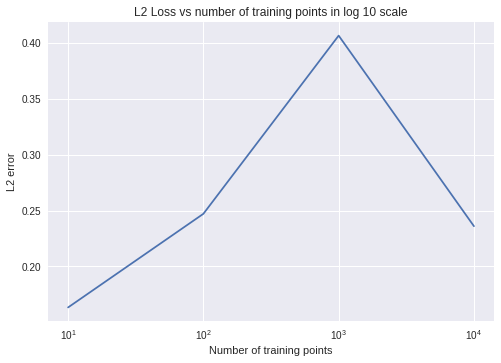

In [0]:
l2_errors = []
for N in [10,100,1000,10000]:
  physically_informed_nn = PhysicallyInformedNN(N)
  l2_error = physically_informed_nn.l2_error()
  l2_errors.append(l2_error)
plt.plot([10,100,1000,10000],l2_errors)
plt.title('L2 Loss vs number of training points in log 10 scale')
plt.xscale('log')
plt.xlabel('Number of training points')
plt.ylabel('L2 error')

## Q3

In [0]:
class VanillaNeuralClassifier:
  def __init__(self,X,y,num_hidden_layers = None,num_neurons = None):
    X  = (X - np.mean(X,axis = 0)) / np.std(X,axis = 0)
    self.Xy = np.hstack((X,np.ones((X.shape[0],1)),y))
    np.random.shuffle(self.Xy)
    self.train_Xy = self.Xy[:6667]
    self.test_X = self.Xy[6667:,:-1]
    self.test_y = self.Xy[6667:,-1]
    self.W = [np.vstack((np.random.randn(12,1) * np.sqrt(2 / 13),np.zeros((1,1))))]
    self.batch_size = 32
    self.num_hidden_layers = num_hidden_layers
    self.iteration_num = 10000
    self.beta_one = .9
    self.beta_two = .999
    self.epsilon = 1e-8    
    if num_hidden_layers:
       self.W = [np.vstack([np.random.randn(12,num_neurons) * np.sqrt(2 / (12 + num_neurons)), np.zeros((1,num_neurons))])] + \
                [np.vstack([np.random.randn(num_neurons,num_neurons),np.zeros((1,num_neurons))])] * self.num_hidden_layers + \
                [np.vstack([np.random.randn(num_neurons,1) * np.sqrt(2 / (1 + num_neurons)), np.zeros((1,1))])]
        
        
  def sigmoid(self,x):
    return 1 / (1 + np.exp(-x))
  def relu(self,x):
    return np.maximum(x,np.zeros(x.shape))
  def forward(self,X,W):
    out = np.matmul(X,W[0])
    if len(W) > 1:
      for j in range(self.num_hidden_layers + 1):
        out = self.relu(out)
        out = np.hstack([out,np.ones((out.shape[0],1))])
        out = np.matmul(out,W[j + 1])
    return self.sigmoid(out)
  def loss(self,X,y,W):
    yhat = self.forward(X,W)
    return - np.sum(y * np.log(yhat + self.epsilon) + (1 - y) * np.log(1 - yhat + self.epsilon),axis = 0) / self.batch_size
  def optimizer(self,learning_rate):
    
    loss = np.zeros((self.iteration_num,1))
    locator = 0
    W = self.W
    m = [np.zeros(w.shape) for w in W]
    v = [np.zeros(w.shape) for w in W]
    grad_losses = grad(self.loss,2)
    for iter_num in range(self.iteration_num):
      # shuffle dataset here
      np.random.shuffle(self.train_Xy)
      train_x = self.train_Xy[:,:-1]
      train_y = self.train_Xy[:,-1].reshape(train_x.shape[0],1)
      this_X = train_x[:self.batch_size]
      this_y = train_y[:self.batch_size]
      this_loss = self.loss(this_X,this_y,W)
      loss[locator] = this_loss
      for i in range(len(W)):
        this_loss_gradient = grad_losses(this_X,this_y,W)[i]
        m[i] = self.beta_one * m[i] + (1 - self.beta_one) * this_loss_gradient
        v[i] = self.beta_two * v[i] + (1 - self.beta_two) * np.multiply(this_loss_gradient,this_loss_gradient)
        m_dot = m[i] / (1 - self.beta_one ** (iter_num + 1))
        v_dot = v[i] / (1 - self.beta_two ** (iter_num + 1))
        W[i] -= learning_rate * m_dot / (np.sqrt(v_dot) + self.epsilon)
      locator += 1
    return W,loss
  def test_accuracy(self):
    W,_ = self.optimizer(.001)
    pred = np.round(self.forward(self.test_X,W)).astype('int')
    acc = accuracy_score(self.test_y,pred)
    return acc
    
      

In [0]:
file = pd.read_csv('Data_for_UCI_named.csv.csv')
lb = LabelBinarizer()
#here unstable is 1 and stable is 0
y_q3 = lb.fit_transform(file['stabf'])
X_q3 = file.drop(columns = ['stab','stabf']).as_matrix()


The accuracy table is provided below,  One thing to note is no the result from no hidden layer is repeatedly printed for visualization sake.


In [0]:
accuracy_table = []
for num_hidden_layer in [None,1,2,3]:
  if num_hidden_layer is None:
    vnc = VanillaNeuralClassifier(X_q3,y_q3)
    accuracies = [vnc.test_accuracy()] * 3
  else:
    accuracies = []
    for num_cells in [20,50,100]:
      vnc = VanillaNeuralClassifier(X_q3,y_q3,num_hidden_layer,num_cells)
      accuracies.append(vnc.test_accuracy())
  accuracy_table.append(accuracies) 
accuracy_matrix = np.array(accuracy_table)
accuracy_table = pd.DataFrame(accuracy_matrix,columns = ['20 cells','50 cells','100 cells'],index = ['No hidden layer','1 hidden layer','2 hidden layers','3 hidden layers'])
print('accuracy table is')
print(accuracy_table)

/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


accuracy table is
                 20 cells  50 cells  100 cells
No hidden layer  0.811881  0.811881   0.811881
1 hidden layer   0.939694  0.954995   0.951695
2 hidden layers  0.940894  0.934293   0.938794
3 hidden layers  0.925293  0.916592   0.903690
